In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import glob
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve, validation_curve
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

## Meteorological data

In [2]:
rain_files = '../../../../time_series/analisi/CTBTO/raw_data/gards_met_data/'

In [3]:
rain_dict = {}
for file in glob.glob(rain_files+'*.csv'):
    rain_dict[int(file.split('/')[-1][:-4])] = pd.read_csv(file)

### RAIN_FALL = 0 -> no rain | RAIN_FALL > 0 -> rain

In [4]:
del_keys = []
for key in rain_dict.keys():
    df = rain_dict[key]
    rain_perc = len(df[df.RAIN_FALL > 0])/len(df)*100
    #only keep stations with at least 1/10 of rainy days
    if rain_perc > 10.0:
        print('Station {} rain percentage: {:.2f}%'.format(df.STATION_ID.iloc[0], rain_perc))
    else:
        del_keys.append(key)
for key in del_keys:
    rain_dict.pop(key)

Station 579 rain percentage: 69.68%
Station 580 rain percentage: 90.83%
Station 524 rain percentage: 23.39%
Station 535 rain percentage: 11.77%
Station 539 rain percentage: 23.65%
Station 517 rain percentage: 40.30%


In [9]:
def rain_encoder(v):
    if v <= 0.0:
        return 0
    elif v > 0.0:
        return 1

# Station 579

In [20]:
rain_dict[579].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539106 entries, 0 to 539105
Data columns (total 9 columns):
STATION_ID        539106 non-null int64
HUMIDITY          539106 non-null int64
TEMPERATURE       539106 non-null float64
PRESSURE          539106 non-null float64
WIND_DIRECTION    539106 non-null int64
WIND_SPEED        539106 non-null float64
RAIN_FALL         539106 non-null float64
START_TIME        539106 non-null object
END_TIME          539106 non-null object
dtypes: float64(4), int64(3), object(2)
memory usage: 37.0+ MB


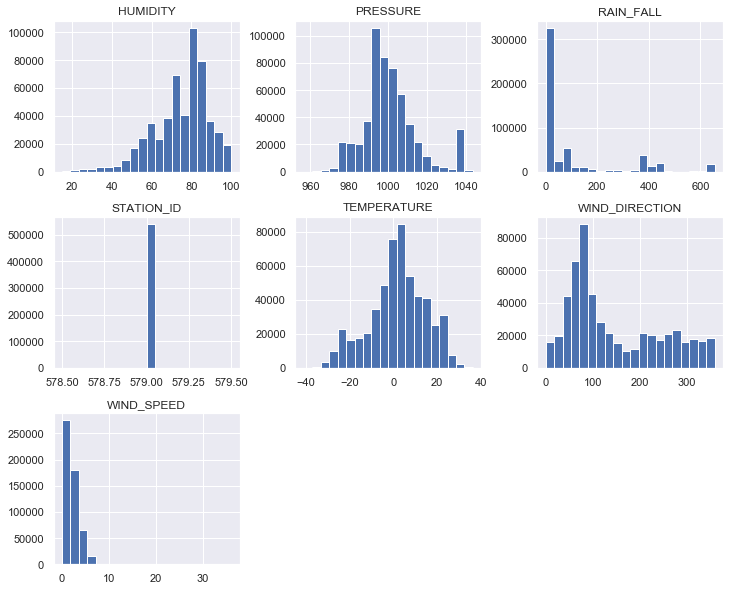

In [24]:
h = rain_dict[579].hist(bins=20, figsize=(12,10))

In [12]:
X = rain_dict[579][['HUMIDITY', 'TEMPERATURE', 'PRESSURE', 'WIND_DIRECTION', 'WIND_SPEED']]
y = rain_dict[579].RAIN_FALL.apply(lambda x: rain_encoder(x))

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

In [18]:
print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_test shape: {}'.format(X_test.shape))
print('y_test shape: {}'.format(y_test.shape))

X_train shape: (485195, 5)
y_train shape: (485195,)
X_test shape: (53911, 5)
y_test shape: (53911,)


### Logistic regression

In [45]:
pipe_lr = Pipeline([('scaler', StandardScaler()),
                    ('clf_lr', LogisticRegression(penalty='l2', random_state=0))])
param_range_C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid_lr = {'clf_lr__C': param_range_C,
                 'clf_lr__solver': ['newton-cg', 'lbfgs']}
scoring_lr = {'acc': 'accuracy', 'prec': 'precision', 'rec': 'recall', 'auc': 'roc_auc', 'f1': 'f1'}
gs_lr = GridSearchCV(estimator=pipe_lr, param_grid=param_grid_lr, scoring=scoring_lr, cv=10, refit='f1')
gs_lr.fit(X_train, y_train)

//anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:426: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
//anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
//anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
//anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('clf_lr',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=100,
                                                           multi_class='

In [40]:
print('Logistic regression accuracy = {}'.format(gs_lr.best_score_))
print('Logistic regression best parameters = {}'.format(gs_lr.best_params_))

Logistic regression accuracy = 0.6950401385010151
Logistic regression best parameters = {'clf_lr__C': 10, 'clf_lr__solver': 'newton-cg'}


In [42]:
print('Logistic regression precision = {}'.format(gs_lr.best_score_))
print('Logistic regression best parameters = {}'.format(gs_lr.best_params_))

Logistic regression precision = 0.735906477845303
Logistic regression best parameters = {'clf_lr__C': 10, 'clf_lr__solver': 'newton-cg'}


In [44]:
print('Logistic regression recall = {}'.format(gs_lr.best_score_))
print('Logistic regression best parameters = {}'.format(gs_lr.best_params_))

Logistic regression recall = 0.8992567421351496
Logistic regression best parameters = {'clf_lr__C': 0.0001, 'clf_lr__solver': 'lbfgs'}


In [38]:
print('Logistic regression AUC = {}'.format(gs_lr.best_score_))
print('Logistic regression best parameters = {}'.format(gs_lr.best_params_))

Logistic regression AUC = 0.7610803996724
Logistic regression best parameters = {'clf_lr__C': 0.001, 'clf_lr__solver': 'lbfgs'}


In [46]:
print('Logistic regression f1 = {}'.format(gs_lr.best_score_))
print('Logistic regression best parameters = {}'.format(gs_lr.best_params_))

Logistic regression f1 = 0.8006733784210616
Logistic regression best parameters = {'clf_lr__C': 0.0001, 'clf_lr__solver': 'lbfgs'}


`In the case of rain, it is better to minimise the false negatives, hence to have a high recall.`

`Precision should be high enough too.`

In [49]:
pipe_lr_best = Pipeline([('scaler', StandardScaler()),
                         ('clf_lr', LogisticRegression(penalty='l2', C=0.0001, solver='lbfgs', random_state=0))])
prc = cross_val_score(estimator=pipe_lr_best, X=X_train, y=y_train, cv=10, scoring='precision')
print('Precision corresponding to the parameters with the best recall: {}', np.mean(prc))

Precision corresponding to the parameters with the best recall: {} 0.7215702231752894


In [63]:
param_range_C_best = np.arange(0.00005, 0.0005, 0.00001)
train_scores_rec, test_scores_rec = validation_curve(estimator=pipe_lr_best, X=X_train, y=y_train,
                                                     param_name='clf_lr__C', param_range=param_range_C_best,
                                                     cv=10, scoring='recall')
train_scores_prc, test_scores_prc = validation_curve(estimator=pipe_lr_best, X=X_train, y=y_train,
                                                     param_name='clf_lr__C', param_range=param_range_C_best,
                                                     cv=10, scoring='precision')

ValueError: x and y must have same first dimension, but have shapes (45,) and (435,)

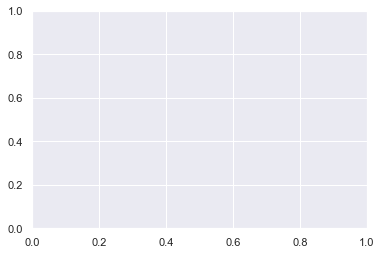

In [59]:
train_mean_rec = np.mean(train_scores_rec, axis=1)
train_std_rec = np.std(train_scores_rec, axis=1)
test_mean_rec = np.mean(test_scores_rec, axis=1)
test_std_rec = np.std(test_scores_rec, axis=1)
plt.plot(param_range_C_best, train_mean_rec, 'go', label='training recall')
plt.fill_between(param_range_C_best, train_mean_rec+train_std_rec, train_mean_rec-train_std_rec,
                 alpha=0.15, color='g')
plt.plot(param_range_C_best, test_mean_rec, 'ro', label='validation recall')
plt.fill_between(param_range_C_best, test_mean_rec+test_std_rec, test_mean_rec-test_std_rec,
                 alpha=0.15, color='r')
plt.xlabel('C')
plt.ylabel('Recall')
plt.legend(loc=0)
plt.title('Max recall: {} | C = {}'.format(np.max(test_mean),
                                           param_range_C_best[np.where(test_mean==np.max(test_mean))]))

In [58]:
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr_best, X=X_train, y=y_train,
                                                        train_sizes=np.arange(1000, 436000, 1000),
                                                        cv=10, scoring='recall')

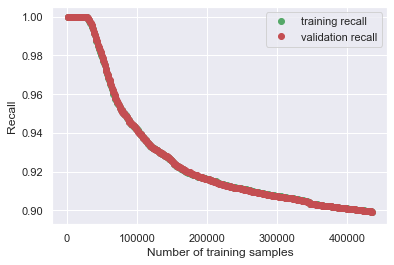

In [62]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_mean, 'go', label='training recall')
plt.fill_between(train_sizes, train_mean+train_std, train_mean-train_std, alpha=0.15, color='g')
plt.plot(train_sizes, test_mean, 'ro', label='validation recall')
plt.fill_between(train_sizes, test_mean+test_std, test_mean-test_std, alpha=0.15, color='r')
plt.xlabel('Number of training samples')
plt.ylabel('Recall')
plt.legend()
#plt.ylim(0.998, 1.002)